**PRÁCTICA 2. INTRODUCCIÓN A TENSORFLOW: OPTIMIZACIÓN Y REGRESIÓN LINEAL**

**Conceptos necesarios de teoría**:
Tensores en TF, Variables vs Placeholders, SGD, Boston dataset

En la práctica anterior, programamos el **Fordward Pass** y el algoritmo básico del aprendizaje profundo, el **Backpropagation**, empleando la librería científica **Numpy**. El código que desarrollamos no estaba optimizado ni ampliamente validado. Debido a estos dos aspectos, cuando se desean entrenar redes neuronales se hace uso de librerias de más alto nivel. En esta segunda sesión práctica vamos a trabajar con la librería **TensorFlow**. ¿Como importamos dicha librería en nuestro Notebook de Colab?

In [0]:
import tensorflow as tf
print(tf.__version__)

1.14.0-rc1


TensorFlow es un framework desarrollado y mantenido por **Google** que permite la ejecución de operaciones matemáticas, mediante diagramas de flujo de datos, de una forma optimizada en una CPU o GPU. Vamos a **listar los dispositivos locales** para comprobar que tenemos disponible la GPU que Google Colab nos ofrece:

In [0]:
from tensorflow.python.client import device_lib

def get_available_devices():
  local_device_protos = device_lib.list_local_devices()
  return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


Vaya... ¿Por qué aparecen 2 CPUs y 2 GPUs?**¿Que significa XLA?** Efectua una búsqueda rápida en Google para salir de dudas.

Tal y como hemos visto en el apartado teórico, TensorFlow tiene unas características un tanto peculiares:

1.   TensorFlow utiliza **tensores** para realizar las operaciones.

2.   En TensorFlow, **primero se definen las operaciones a realizar** (construimos el **grafo**), y **luego se ejecutan** (se ejecuta el grafo).

3.   Permite ejecutar el código implementado paralelamente o en **una o varias GPUs**, a elección del usuario.

Sin más dilación vamos a ver como se define un tensor y como se pueden realizar operaciones básicas entre ellos. Ves ejecutando cada una de las celdas y asegúrate que comprendes la salida de todos los comandos *print*.

In [0]:
import numpy as np
import tensorflow as tf

# Creo un numpy array
arr1d = np.array([1, 5.5, 3, 15, 20])

# Del cual puedo ver tanto su contenido como ciertas propiedades
print(arr1d)
print (arr1d.ndim)
print (arr1d.shape)
print (arr1d.dtype)

[ 1.   5.5  3.  15.  20. ]
1
(5,)
float64


In [0]:
# Cuando convierto a tensor y trato de ver el contenido ya no es posible
tensor1d = tf.convert_to_tensor(arr1d,tf.float64)
print(tensor1d)

# Para ver el contenido de un tensor tengo que ejecutar una sesión
sess = tf.Session() # ¡¡¡ Busca en la documentación de TensorFlow información acerca de una sesión !!!
print(sess.run(tensor1d))

Tensor("Const:0", shape=(5,), dtype=float64)
[ 1.   5.5  3.  15.  20. ]


In [0]:
# Vamos a sumar dos tensores
tensor1d_bis = tf.convert_to_tensor([9, 4.5, 7, 5, 0], tf.float64)
my_sum = tf.add(tensor1d, tensor1d_bis)
sess = tf.Session()
print(sess.run(my_sum))

[10. 10. 10. 20. 20.]


In [0]:
# Multipliquemoslos (elemento a elemento)
my_mul = tf.multiply(tensor1d, tensor1d_bis) # Producto elemento a elemento
sess = tf.Session()
print(sess.run(my_mul))

[ 9.   24.75 21.   75.    0.  ]


In [0]:
# Ahora un producto escalar de tensores 1D
product1 = tf.tensordot(tensor1d, tensor1d_bis, 1) # OJO! No hace falta transponer
sess = tf.Session()
print(sess.run(product1))

129.75


In [0]:
# Vamos con un producto vectorial de tensores 2D
matrix1 = tf.constant([[3., 3.]])
matrix2 = tf.constant([[2.], [2.]])
product2 = tf.matmul(matrix1, matrix2) # Producto matricial
sess = tf.Session()
print(sess.run(matrix1))
print(sess.run(matrix2))
print(sess.run(product2))

[[3. 3.]]
[[2.]
 [2.]]
[[12.]]


In [0]:
sess2 = tf.Session()
matrix1 = tf.constant([[1., 1.]])
matrix2 = tf.constant([[2.], [2.]])
product2 = tf.matmul(matrix1, matrix2) # Producto matricial
print(sess2.run(product2))

[[4.]]


¿Que tal estas primeras operaciones empleando TensorFlow? Si os habeís fijado detenidamente hay un par de instrucciones que hemos ido repitiendo a lo largo de las operaciones. **``sess = tf.Session()``** es la instrucción básica de TF, con ella abrimos una nueva sesión durante la cuál podremos realizar las operaciones deseadas. Dichas operaciones se definen en forma de grafo, bien antes de abrir la sesión o una vez abierta (mediante sentencias como **``grafo = tf.add(x1, x2)``**; **``grafo = tf.multiply(x1, x2)``**; **``grafo = tf.tensordot(x1, x2, axis)``**, etc.). Una vez creado el grafo, con la expresión **``tf.run(grafo)``** ejecutamos todas las operaciones contenidas en el mismo (i.e. se ejecuta la última operación y las operaciones contenidas en las variables de entrada de dicha última operación).

Es importante destacar que también es posible abrir una nueva sesión empleando el comando **``with``** y sobre todo que la sesión debe cerrarse para liberar los recursos mediante el comando **``sess.close()``**.


In [0]:
with tf.Session() as sess:
  my_res = sess.run([product2])
  print(my_res)
sess.close()

[array([[4.]], dtype=float32)]


Como se ha comentado anteriormente, el código implementado se puede ejecutar en CPU, en GPU o en multiples GPUs. Mediante TF podemos listar los diferentes dispositivos (como ya hemos visto) y **ejecutar una sesión utilizando el/los dispositivo/s que creamos conveniente/s**:

In [0]:
with tf.Session() as sess:
  with tf.device("/device:XLA_GPU:0"):
    matrix1 = tf.constant([[3., 3.]])
    matrix2 = tf.constant([[2.],[2.]])
    last_prod = tf.matmul(matrix1, matrix2)
    print(sess.run(last_prod))
sess.close()

[[12.]]


El último aspecto que nos queda por introducir son las **sesiones interactivas** que brinda TF. Mediante una sesión interactiva es posible establecer una sesión activa por defecto mientras esta se encuentra bajo construcción. Empleando el método **``tf.TENSOR.eval()``** se puede visualizar el contenido de un tensor sin necesidad de tener que ejecutar el grafo tal y como haciamos en una sesión estática (recuerda mediante **``tf.run(grafo)``**). De la misma forma es posible llevar a cabo las operaciones que se deseen mediante el comando **``tf.OPERACION.run()``**. Vamos a ejemplificar el concepto de sesión interactiva creando una distribución Gaussiana y graficándola.

$f(x) = \dfrac{1}{\sigma\sqrt{2\pi}}e^{-\dfrac{1}{2}\left(\dfrac{x-\mu}{\sigma}\right)^2}$

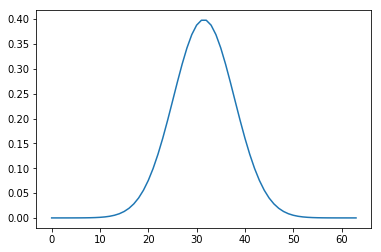

In [0]:
# Importo librerias necesarias para visualización
import matplotlib.pyplot as plt

# Inicio sesión interactiva
sess = tf.InteractiveSession()

# Parámetros
n_values = 64
sigma = 1.0
mean = 0

# Creo Gaussiana de 64 vaores y muestro
x = tf.linspace(-5.0, 5.0, n_values)
x.eval()
gaussian_function = (tf.exp(tf.negative(tf.pow(x-mean, 2) / (2.0 * tf.pow(sigma, 2.0)))) * (1.0 / (sigma * tf.sqrt(2.0 * np.pi))))
plt.plot(gaussian_function.eval())

# Cierro sesión interactiva
sess.close()
tf.InteractiveSession.close(sess)

Por el momento todo el contenido que hemos ido creando lo hemos asigando directamente a diferentes variables. Concretamente en el ejemplo anterior hemos almacenado $n$ puntos equiespaciados en el rango [-5,5] en la variable **``x``**, mientras que los valores de la distibución Gaussiana los hemos almacenado en una variable denominada **``gaussian_function``**. Dichas **variables** son **definidas e inicializadas con un tensor de determinas dimensiones** y el **contenido de las mismas puede ir actualizandose en tiempo de ejecución**, por ejemplo, en el proceso de actualización de los pesos de una red neuronal. 

En TF a parte de variables existen **``placeholders``**. Los placeholders no son más que **resrvas de espacios de memoria**. Dichas resrvas de memoria se pueden realizar **definiendo las dimensiones** del tensor que contendrá el placeholder **o sin definirlas**, puesto que se trata de reserva de memoria dinámica. El contenido de un placeholder **se rellena en tiempo de ejecución** (i.e. cuando ejecutamos **``tf.Session.run()``**) y se utiliza mayoritariamente para alimentar al grafo con datos de entrada, por ejemplo, en un placeholder almacenariamos el dataset para entrenar una red neuronal. A diferencia de las variables, **los placeholders no pueden modificar su contenido en tiempo de ejecución**. Vamos a ver un ejemplo para entenderlo mejor:

In [0]:
# Instanciemos un placeholder definiendo dimensiones
x = tf.placeholder(tf.int32, shape=[4])
print (x.get_shape())
# El valor que proporciona x.get_shape() son las dimensiones estáticas de x (en este caso un vector de 4 elementos)

# Apliquemos la función unique ¡¡¡ Busca en la documentación de TF para que sirve dicha función !!!
y, _ = tf.unique(x)
print (y.get_shape())

#¿Que está ocurriendo?¿Por que sucede esto? 
# Sol. No se puede ver las dimensiones de un placeholder ya que se rellena en tiempo de ejecución

(4,)
(?,)


In [0]:
# Vamos a ejecutar el grafo en una sesión
sess = tf.Session()
print (sess.run(y, feed_dict={x: [0, 1, 1, 3]}).shape) # Ejemplo 1
print (sess.run(y, feed_dict={x: [0, 0, 0, 0]}).shape) # Ejemplo 2
sess.close()

# ¿Que sucede ahora?¿Por qué las dimensiones son conocidas? Justifica las dimensiones que salen
# En tiempo de ejecución si que se puede ver las dimensiones del placeholder
# Al ejecutar el grafo las posiciones de memoria se rellenan con los datos
# Ej1 hay 3 escalares distintos mientras que en Ej2 solo hay ceros.

(3,)
(1,)


Una vez introducido lo que es un tensor y la forma de operar con ellos, vamos a dirigir ya el uso de TF al ámbito de las redes neuronales. Tal y como hemos visto en lo que llevamos de teoría como en la sesión práctica anterior, el **corazón de una red neuronal** es el algoritmo de **backpropagation** que tiene como objetivo optimizar los pesos **minimizando** la **función de pérdidas** o **función de coste**. ¿Y como podemos minimizar una determinada función empleando TF?  Pues vamos a verlo con un ejemplo, vamos a minimizar la función $f(x)=log(x)^2$: 

In [0]:
# Hallemos el mínimo de la función y = log(x)^2
x = tf.Variable(2, dtype=tf.float32) # Le damos un primer valor a nuestra x
y = tf.square(tf.log(x)) # Definimos la función
opt = tf.train.GradientDescentOptimizer(0.5) # Instanciamos el optimizador pasandole como parámetro el learning rate
train = opt.minimize(y) # Minimizamos función

init = tf.initializers.global_variables() # Inicializamos las variables ¡¡¡ Busca en la documentación de TF información acerca de este método !!!

with tf.Session() as session: # Ejecutamos los grafos
    session.run(init)
    print('[INFO]: Starting at', 'x = ', session.run(x), '- log(x)^2:', session.run(y))
    for step in range(10):
      session.run(train)
      print('[INFO]: Step ', step, '---> x: ', session.run(x), '- log(x)^2: ', session.run(y))

[INFO]: Starting at x =  2.0 - log(x)^2: 0.480453
[INFO]: Step  0 ---> x:  1.6534264 - log(x)^2:  0.25285786
[INFO]: Step  1 ---> x:  1.3493005 - log(x)^2:  0.08975195
[INFO]: Step  2 ---> x:  1.1272697 - log(x)^2:  0.014351694
[INFO]: Step  3 ---> x:  1.0209966 - log(x)^2:  0.0004317743
[INFO]: Step  4 ---> x:  1.0006447 - log(x)^2:  4.1534943e-07
[INFO]: Step  5 ---> x:  1.0000006 - log(x)^2:  3.5527118e-13
[INFO]: Step  6 ---> x:  1.0 - log(x)^2:  0.0
[INFO]: Step  7 ---> x:  1.0 - log(x)^2:  0.0
[INFO]: Step  8 ---> x:  1.0 - log(x)^2:  0.0
[INFO]: Step  9 ---> x:  1.0 - log(x)^2:  0.0


Mínimo de la función y =  0.00010100925076817785  en x=  1.0101010101010102


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


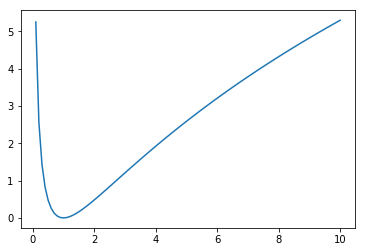

In [0]:
# Representa (empleando matplotlib) la función y = log(x)^2 y obten el mínimo y la posición del mismo empleando numpy
# Para ello, crea un vector de 100 puntos equiespaciados en el rango [0,10] (ver np.linspace)
x_values = np.linspace(0, 10, 100) #(X) 
fx = np.log(x_values)**2 #(X) 
print('Mínimo de la función y = ', np.min(fx), ' en x= ', x_values[np.argmin(fx)]) #(X) 
plt.plot(x_values,fx) #(X) 


A continuación responda a las siguientes cuestiones acerca del ejemplo anterior:

- ¿Tienden a la misma solución ambas aproximaciones?¿Que significa esto? **Sol.** Sí ambas aproximaciones tienden al mismo valor mínimo. El SGD nos da una solución bastante certera del mínimo global de la función
- ¿Que efecto tendría sobre el valor del mínimo disminuir el valor de lr? **Sol.** Decrementar el lr puede significar que la precisión del mínimo aumente a costa de mayor CC
- Disminuye la tasa de aprendizaje a lr = 0.05, ¿Que observas?¿Que parámetro del código necesitas modificar para observar resultados coherentes? **Sol.** No le da tiempo a aprender lo suficiente para proporcionar una buena solución. Hay que aumentar el número de steps (épocas) a entrenar



---



Para poner en práctica todo lo aprendido, vamos a resolver uno de aquellos problemas de optimización típicos de bachillerato mediante TensorFlow.

**EJERCICIO 1.**  Xiaomi va a lanzar al mercado un nuevo smartphone y quiere diseñar el packaging del mismo. La idea es desarrollar un envase en forma de prisma de base cuadrada. El volumen del envase debe ser de 80 $cm^3$. El material para fabricar las caras laterales y la tapa del envase cuesta 1 céntimo de euro por $cm^2$. El material para fabricar la base debe ser más resistente y cuesta 1.5 céntimos de euro por $cm^2$.

1.   Calcula las dimensiones del envase para que su coste sea el menor posible.
2.   Calcula cuál es el coste mínimo, expresado en euros, que tendrá el envase.

Si recordaís con los datos del encunciado debemos plantear un sistema de ecuaciones. Una de las ecuaciones nos proporcionará una relación y la otra será la función objetivo a minimizar. VAMOS ALLÁ:

- El volumen de un prisma es $Vp = x * y * h$, como sabemos que la base es cuadrada: $Vp = x*x*h = 80$.
- Por otra parte tenemos que plantear otra ecuación que involucre la superficie del envase y la relacione con el coste: $C(x) = 1c€/cm^2 * (4x*h + x^2) + 1.5 c€/cm^2 * x^2$ = $4xh+x^2 + 1.5x^2$ = $4xh+2.5x^2$.

Bien, ahora que ya tenemos las dos ecuaciones, de la primera de ellas (la relación) despejamos $x$ y la sustituimos en la función de coste (función objetivo o función a minimizar), resultando:

$C(x) = \dfrac{320}{x} + 2.5x^2$

Esta es la función objetivo que debeís minimizar haciendo uso de la librería TensorFlow, tal y como hemos hecho antes con la función $y = log(x)^2$, para poder responder a las dos cuestiones planteadas en el enunciado.

In [0]:
# Hallemos el mínimo de la función C(x) = 320/x + 2.5x^2

# Inicialización de la variable x (Utiliza la función random_uniform de TF)
x = tf.Variable(initial_value=tf.random_uniform([1], 0., 50.), name='x') #(X)

# Función de coste a minimizar
c = tf.add(tf.divide(320,x), tf.multiply(2.5, tf.square(x)), name='c') #(X)

#Instanciar el optimizardor pasándole como parámetro el learning rate
opt = tf.train.GradientDescentOptimizer(0.005) #(X)

# Minimizar la función objetivo
train = opt.minimize(c) #(X)

# Inicializar las variables del grafo
init = tf.initializers.global_variables() #(X) 

# Ejecución del grafo
with tf.Session() as session:
    session.run(init) #Inicializar variables (X)
    old_solution = 0
    tolerance = 1e-4
    for step in range(500): # Dejar vacío el parámetro de número de pasos
      session.run(train) # Entrenamos (X)
      solution = session.run(x) # Nueva solución (X)
      # Comprobamos si se ha alcanzado la solución óptima
      if np.abs(solution - old_solution) < tolerance:
        print("\n El envase óptimo tendrá dimensiones x = {} cm, h = {} cm dando lugar a un coste de C = {} €".format(solution, 80/(solution*solution), session.run(c)/100))
        break
      # Si no es así actualizo la solución vieja y muestro por pantalla 1 de cada 10 iteraciones
      old_solution = solution
      if step % 10 == 0:
        print('[INFO]: Step ', step, "---> x = " + str(old_solution), "- C = " + str(session.run(c)))

[INFO]: Step  0 ---> x = [28.433863] - C = [2032.4656]
[INFO]: Step  10 ---> x = [22.096739] - C = [1235.1465]
[INFO]: Step  20 ---> x = [17.191883] - C = [757.51556]
[INFO]: Step  30 ---> x = [13.408433] - C = [473.33075]
[INFO]: Step  40 ---> x = [10.510603] - C = [306.62735]
[INFO]: Step  50 ---> x = [8.322948] - C = [211.62659]
[INFO]: Step  60 ---> x = [6.717211] - C = [160.44113]
[INFO]: Step  70 ---> x = [5.5961094] - C = [135.4737]
[INFO]: Step  80 ---> x = [4.87121] - C = [125.01381]
[INFO]: Step  90 ---> x = [4.4451256] - C = [121.386826]
[INFO]: Step  100 ---> x = [4.216705] - C = [120.34014]
[INFO]: Step  110 ---> x = [4.102445] - C = [120.07741]
[INFO]: Step  120 ---> x = [4.0476747] - C = [120.016914]
[INFO]: Step  130 ---> x = [4.0220146] - C = [120.003624]
[INFO]: Step  140 ---> x = [4.010128] - C = [120.00077]
[INFO]: Step  150 ---> x = [4.004651] - C = [120.00017]
[INFO]: Step  160 ---> x = [4.0021343] - C = [120.00003]

 El envase óptimo tendrá dimensiones x = [4.001

A continuación responda a las siguientes cuestiones acerca del ejemplo anterior:

- ¿Qué valor de tasa de aprendizaje y número de pasos has utilizado para el entrenamiento? Si has empleado los valores del ejercicio anterior observarás un comportamiento un tanto extraño en el proceso de aprendizaje. ¿Que significa esto? **Sol.** La tasa de aprendizaje del ejercicio anterior es muy alta para alcanzar el mínimo global en este problema.

- Prueba a fijar una tasa de aprendizaje 100 veces más pequeña para dar pasos mucho más cortos en la búsqueda de la solución óptima, por consiguiente establece un número de pasos mucho mayor, por ejemplo 500. ¿Que ocurre ahora? Justifica la respuesta. **Sol.** Ahora el proceso de aprendizaje es correcto y se obtienen resultados con mucho sentido. Con esto se ejemplifica perfectamente la importancia del learning rate y el número de épocas. Su influencia se estudiará detenidamente en la siguiente práctica.



---



Para finalizar esta segunda práctica, vamos a realizar una **regresión lineal** sobre un determinado conjunto de datos $X$. Dicha regresión lineal vendrá dada por la ecuación de la recta de la forma $\hat{Y} = XW + b$. La solución óptima del ajuste de la recta ($W_{opt}, b_{opt}$) sobre la distribución de datos se puede obtener minimizando la función error cuadrático medio definida como  $MSE = \frac{1}{N}\sum_{i=1}^{N}(\hat{y}_i - y_i)^2$ donde $N$ es el número de muestras del conjunto de datos e $Y$ es un vector con el *ground truth* de los mismos.

**EJERCICIO 2.** El **Boston dataset** es un conjunto de datos para el análisis de los precios de las viviendas en la región de Boston. Dicho conjunto de datos esta formado por **506 muestras**. Cada una de ellas viene definida por **trece características** de la vivienda en cuestión y su precio de mercado (i.e. target). Es interesante conocer las características de el conjunto de datos, por lo que la primera tarea de este ejercicio es leer detenidamente la descripción del dataset y sus características [aqui](https://www.kaggle.com/c/boston-housing). A continuación, siguiendo las indicaciones anteriores se debe implementar un algoritmo que dado el nombre de una característica y el target, sea capaz de ajustar una recta que permita realizar predicciones futuras.

W0617 09:02:10.967954 139900742862720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[INFO]: Época 0 ---> MSE = 376.6591796875
[INFO]: Época 20 ---> MSE = 133.3729248046875
[INFO]: Época 40 ---> MSE = 128.5937957763672
[INFO]: Época 60 ---> MSE = 124.31694030761719
[INFO]: Época 80 ---> MSE = 120.4109115600586
[INFO]: Época 100 ---> MSE = 116.84326171875
[INFO]: Época 120 ---> MSE = 113.58487701416016
[INFO]: Época 140 ---> MSE = 110.60885620117188
[INFO]: Época 160 ---> MSE = 107.89086151123047
[INFO]: Época 180 ---> MSE = 105.40840911865234
[INFO]: Época 200 ---> MSE = 103.14125061035156
[INFO]: Época 220 ---> MSE = 101.0704116821289
[INFO]: Época 240 ---> MSE = 99.17931365966797
[INFO]: Época 260 ---> MSE = 97.45219421386719
[INFO]: Época 280 ---> MSE = 95.87478637695312
[INFO]: Época 300 ---> MSE = 94.43431854248047
[INFO]: Época 320 ---> MSE = 93.11856842041016
[INFO]: Época 340 ---> MSE = 91.91702270507812
[INFO]: Época 360 ---> MSE = 90.8197250366211
[INFO]: Época 380 ---> MSE = 89.81764221191406
[INFO]: Época 400 ---> MSE = 88.90251159667969
[INFO]: Época 420 -

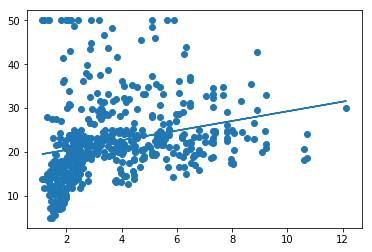

In [0]:
# Importamos y cargamos el dataset
from sklearn import datasets
boston = datasets.load_boston()

# Selección de característica y del target (en este caso precio de la vivienda medio expresado en $1000s)
name_feature = 'DIS' #Probar con RM, NOX y DIS  
f = np.where(boston.feature_names == name_feature)
xs = boston.data[:,f[0][0]]
ys = boston.target
# Número de muestras
n_observations = boston.target.shape[0]

# Crear dos placeholders (en float32) que contendrán tanto los datos (X) como la etiqueta de los mismos (Y)
X = tf.placeholder(tf.float32) #(X)
Y = tf.placeholder(tf.float32) #(X)

# Inicializar W y b con valores aleatorios siguiendo una distribución normal (hacer uso de función random_normal de TF)
W = tf.Variable(tf.random_normal([1]), name='weight') #(X)
b = tf.Variable(tf.random_normal([1]), name='bias') #(X)

# Obtener predicciones (i.e. \hat{Y})
Y_pred = tf.add(tf.multiply(X,W), b) #(X)

# Función de pérdidas (i.e. MSE)
loss = tf.reduce_sum(tf.pow(Y_pred - Y, 2)) / (n_observations - 1) #(X)

# Instanciar optimizador y minimizar MSE
train = tf.train.GradientDescentOptimizer(0.005).minimize(loss) #(X)

# Inicializar las variables del grafo
init = tf.initializers.global_variables() #(X) 

# Número de iteraciones de entrenamiento
n_epochs = 2500

# Ejecución del grafo
with tf.Session() as session:
  session.run(init) #(X)
  prev_training_loss = 0.0
  for epoch_i in range(n_epochs):
    for (x, y) in zip(xs, ys):
      # Lanzar el entrenamiento pasando cada vez un punto de nuestro set de datos (documentación Session.run, parámetro feed_dict)
      session.run(train, feed_dict={X: x, Y: y}) #(X)
    # Cálcular MSE tras de la época en cuestión empleando todos los datos (documentación Session.run, parámetro feed_dict)     
    training_loss = session.run(loss, feed_dict={X: xs, Y: ys}) #(X)
      
    if epoch_i % 20 == 0:
      print("[INFO]: Época {} ---> MSE = {}".format(epoch_i, training_loss))
        
    if(np.abs(prev_training_loss - training_loss) < 0.000001):
      break;
    prev_training_loss = training_loss
    
  # Dibujamos el resultado.
  plt.scatter(xs, ys)
  plt.plot(xs, Y_pred.eval(feed_dict={X: xs}, session=session))